## Importing libraries

In [1]:
# Required Packages
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Supplementary Packages
import random
from itertools import cycle
from collections import defaultdict

# Components for TensorFlow and Keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Hugging Face Transformer Integration
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig

2024-04-11 13:11:14.272224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 13:11:14.272280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 13:11:14.273635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 13:11:14.284582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data preperation

In [2]:
# Custom F1 Metric Function for Model Performance Evaluation
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1_score = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32

        def calc_recall(y_true, y_pred):
            tp = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
            possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
            recall = tp / (possible_positives + tf.keras.backend.epsilon())
            return recall

        def calc_precision(y_true, y_pred):
            tp = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
            predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
            precision = tp / (predicted_positives + tf.keras.backend.epsilon())
            return precision

        precision = calc_precision(y_true, y_pred)
        recall = calc_recall(y_true, y_pred)
        f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

        self.f1_score.assign(f1)

    def result(self):
        return self.f1_score

    def reset_states(self):
        self.f1_score.assign(0)

### Data prep

Data Snapshot:
------------------------------------------------------------
                                            sentence    emotion
0                                    That game hurt.    sadness
1                                 Man I love reddit.  happiness
2  Right? Considering its such an important docum...  happiness
3  He isn't as big, but he's still quite popular....    disgust
4  That's crazy; I went to a super [RELIGION] hig...  happiness
Data Overview:
----------------------------------
               sentence    emotion
count            740821     740821
unique           740821          6
top     That game hurt.  happiness
freq                  1     232675
Distribution of Emotions:
-------------------------
emotion
happiness    232675
sadness      158474
anger         97627
fear          97467
surprise      84407
disgust       70171
List of Unique Emotional Labels:
-----------------------------
sadness
happiness
disgust
surprise
anger
fear


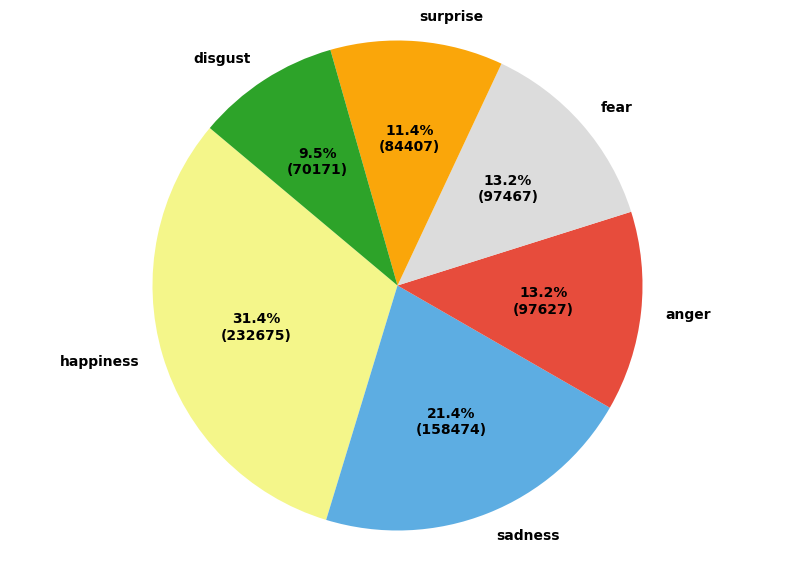

In [3]:
def aggregate_datasets(paths_to_data):
    """Aggregate multiple data sources into a single DataFrame."""
    data_aggregate = [pd.read_csv(path) for path in paths_to_data]
    unified_data = pd.concat(data_aggregate, ignore_index=True)
    unified_data.drop_duplicates(subset='sentence', keep='first', inplace=True)
    return unified_data

def reveal_data_details(data):
    """Present a variety of details concerning the data."""
    print("=" * 60)
    print("Data Snapshot:")
    print("-" * 60)
    print(data.head())
    print("=" * 60)

    print("Data Overview:")
    print("-" * 34)
    print(data.describe(include='all'))
    print("=" * 34)

    print("Distribution of Emotions:")
    print("-" * 25)
    print(data['emotion'].value_counts().to_string())
    print("=" * 25)

    print("List of Unique Emotional Labels:")
    print("-" * 29)
    labels_unique = data['emotion'].unique()
    for label in labels_unique:
        print(label)
    print("=" * 29)

def extract_text_and_labels(data):
    """Isolate text and labels from the data."""
    return data['sentence'].values, data['emotion'].values

# Specifying dataset locations.
paths_to_datasets = [
    'emotions_all_V6.csv',
    'generated_datasets/happiness_sentences_V1.csv',
    'surprise_sentences_V1.csv',
    'surprise_sentences_V2.csv',
    'surprise_sentences_V3.csv',
    'surprise_sentences_V4.csv',
    'generated_datasets/surprise_sentences_V4.csv',
    'disgust_sentences_V1.csv',
    'disgust_sentences_V2.csv',
    'generated_datasets/disgust_sentences_V3.csv',
    'generated_datasets/disgust_sentences_V4.csv',
    'generated_datasets/anger_sentences_V3.csv',
    'generated_datasets/anger_sentences_V5.csv',
    'generated_datasets/anger_sentences_V6.csv',
    'sadness_sentences_V1.csv',
    'generated_datasets/sadness_sentences_V2.csv',
    'generated_datasets/sadness_sentences_V6.csv',
    'generated_datasets/fear_sentences_V3.csv',
    'generated_datasets/fear_sentences_V4.csv',
    'generated_datasets/fear_sentences_V5.csv',
    'generated_datasets/fear_sentences_V6.csv'
]

# Aggregate and unify datasets.
unified_data = aggregate_datasets(paths_to_datasets)

# Displaying comprehensive data information.
reveal_data_details(unified_data)

# Isolating text and emotional labels for subsequent operations.
text_data, emotional_labels = extract_text_and_labels(unified_data)

# Enumerating the counts of different emotions present.
emotions_distribution = unified_data['emotion'].value_counts()

# Function to customize autopct in pie charts, showing both percentage and count.
def custom_autopct(values):
    def format_pct(pct):
        total_count = sum(values)
        actual_value = int(round(pct*total_count/100.0))
        return '{:.1f}%\n({:d})'.format(pct, actual_value)
    return format_pct

# Emotional colors mapping
color_mapping_for_emotions = {
    'happiness': '#F4F68A',
    'sadness': '#5DADE2',
    'anger': '#E74C3C',
    'fear': '#DCDCDC',
    'disgust': '#2DA329',
    'surprise': '#FAA60A'
}

# Matching colors to emotions for visualization
emotional_colors = [color_mapping_for_emotions[emotion] for emotion in emotions_distribution.index if emotion in color_mapping_for_emotions]

# Constructing the pie chart to visualize the distribution of emotions
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(emotions_distribution, labels=emotions_distribution.index, autopct=custom_autopct(emotions_distribution.values),
                                   startangle=140, colors=emotional_colors, textprops={'fontweight': 'bold'})

# Adjusting autopct text color to black
for autotext in autotexts:
    autotext.set_color('black')

plt.axis('equal')  # Ensures pie chart is a circle.
plt.show()

In [4]:
# Setting Hyperparameters and Constants
BATCH_SIZE = 256
LEARNING_RATE = 2e-5
EPOCHS = 100
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_LENGTH = 128
NUM_CLASSES = 6

In [5]:
# Initial Processing of Category Labels
encoder = LabelEncoder()
transformed_labels = encoder.fit_transform(emotional_labels)
transformed_labels = tf.convert_to_tensor(transformed_labels)

2024-04-11 13:11:24.535848: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-11 13:11:24.536205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45248 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [6]:
# Initializing RoBERTa's Tokenizer for Text Data Handling
text_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Setting Up Data Preparation: Token IDs and Attention Masks
token_ids = []
mask_values = []

# Tokenization Process for Each Piece of Text
for text_piece in text_data:
    tokenized_result = text_tokenizer.encode_plus(
                        text_piece,
                        add_special_tokens=True,
                        max_length=MAX_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='tf',
                    )
    
    token_ids.append(tokenized_result['input_ids'])
    mask_values.append(tokenized_result['attention_mask'])

# Converting Lists to Tensors for Model Feeding
token_ids = tf.concat(token_ids, axis=0)
mask_values = tf.concat(mask_values, axis=0)

In [7]:
# Conversion between TensorFlow tensors and numpy arrays as needed
token_ids_array = token_ids.numpy() if isinstance(token_ids, tf.Tensor) else token_ids
mask_values_array = mask_values.numpy() if isinstance(mask_values, tf.Tensor) else mask_values
transformed_labels_array = transformed_labels.numpy() if isinstance(transformed_labels, tf.Tensor) else transformed_labels

# Leveraging scikit-learn to split the dataset for training and validation purposes
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(token_ids_array, transformed_labels_array, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=transformed_labels_array)
training_masks, validation_masks = train_test_split(mask_values_array, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=transformed_labels_array)

# Reformatting numpy arrays back to TensorFlow tensors for model input
X_train_tensors = tf.convert_to_tensor(X_train_split)
X_val_tensors = tf.convert_to_tensor(X_val_split)
y_train_tensors = tf.convert_to_tensor(y_train_split)
y_val_tensors = tf.convert_to_tensor(y_val_split)
training_masks_tensors = tf.convert_to_tensor(training_masks)
validation_masks_tensors = tf.convert_to_tensor(validation_masks)

In [8]:
# Constructing TensorFlow datasets for training and validation
training_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_train_tensors, "attention_mask": training_masks_tensors}, y_train_tensors))
training_dataset = training_dataset.shuffle(len(X_train_tensors)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": X_val_tensors, "attention_mask": validation_masks_tensors}, y_val_tensors))
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Model training

In [9]:
# Configuring the RoBERTa model for sequence classification
model_configuration = RobertaConfig.from_pretrained("roberta-base", num_labels=NUM_CLASSES)
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", config=model_configuration)

# Setting up model training configurations
model_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=model_optimizer, loss=model_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [10]:
# Establishing early stopping to mitigate overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Initiating model training with early stopping and learning rate scheduler callbacks
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


2024-04-11 13:19:50.874378: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1101] failed to allocate 12.19GiB (13087145984 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-04-11 13:19:51.107054: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f24646a9730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-11 13:19:51.107099: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-11 13:19:51.117642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 13:19:51.145597: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1712841591.248606  127000 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2316/2316 [==============================] - 4361s 2s/step - loss: 0.3241 - accuracy: 0.8837 - val_loss: 0.2226 - val_accuracy: 0.9183
Epoch 2/100
2316/2316 [==============================] - 3861s 2s/step - loss: 0.2068 - accuracy: 0.9228 - val_loss: 0.2032 - val_accuracy: 0.9241
Epoch 3/100
2316/2316 [==============================] - 3791s 2s/step - loss: 0.1758 - accuracy: 0.9331 - val_loss: 0.2020 - val_accuracy: 0.9267
Epoch 4/100
2316/2316 [==============================] - 3788s 2s/step - loss: 0.1526 - accuracy: 0.9415 - val_loss: 0.1974 - val_accuracy: 0.9290
Epoch 5/100
2316/2316 [==============================] - 3781s 2s/step - loss: 0.1331 - accuracy: 0.9485 - val_loss: 0.2104 - val_accuracy: 0.9286
Epoch 6/100
2316/2316 [==============================] - 3788s 2s/step - loss: 0.1151 - accuracy: 0.9549 - val_loss: 0.2173 - val_accuracy: 0.9278
Epoch 7/100
2316/2316 [==============================] - 3789s 2s/step - loss: 0.0987 - accuracy: 0.9608 - val_loss: 0.2321 - val_

---

## Plotting visuals

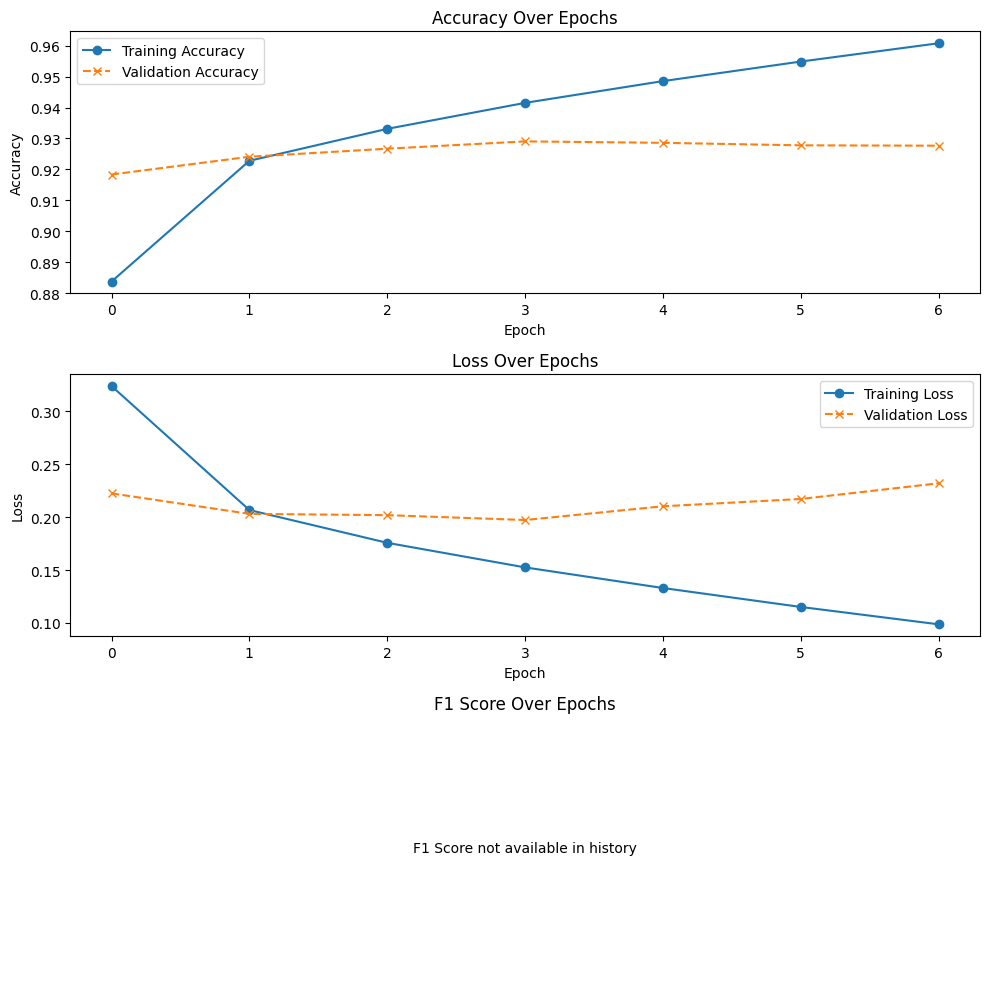

In [11]:
# Visualize the training history
def plot_training_history(history):
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))

    # Accuracy plot with markers
    axes[0].plot(history.history['accuracy'], marker='o', linestyle='-', label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], marker='x', linestyle='--', label='Validation Accuracy')
    axes[0].set_title('Accuracy Over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='best')

    # Loss plot with markers
    axes[1].plot(history.history['loss'], marker='o', linestyle='-', label='Training Loss')
    axes[1].plot(history.history['val_loss'], marker='x', linestyle='--', label='Validation Loss')
    axes[1].set_title('Loss Over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='best')

    # F1 Score plot with markers
    if 'f1_score' in history.history:
        axes[2].plot(history.history['f1_score'], marker='o', linestyle='-', label='Training F1 Score')
        axes[2].plot(history.history['val_f1_score'], marker='x', linestyle='--', label='Validation F1 Score')
        axes[2].set_title('F1 Score Over Epochs')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('F1 Score')
        axes[2].legend(loc='best')
    else:
        axes[2].set_title('F1 Score Over Epochs')
        axes[2].text(0.5, 0.5, 'F1 Score not available in history', horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

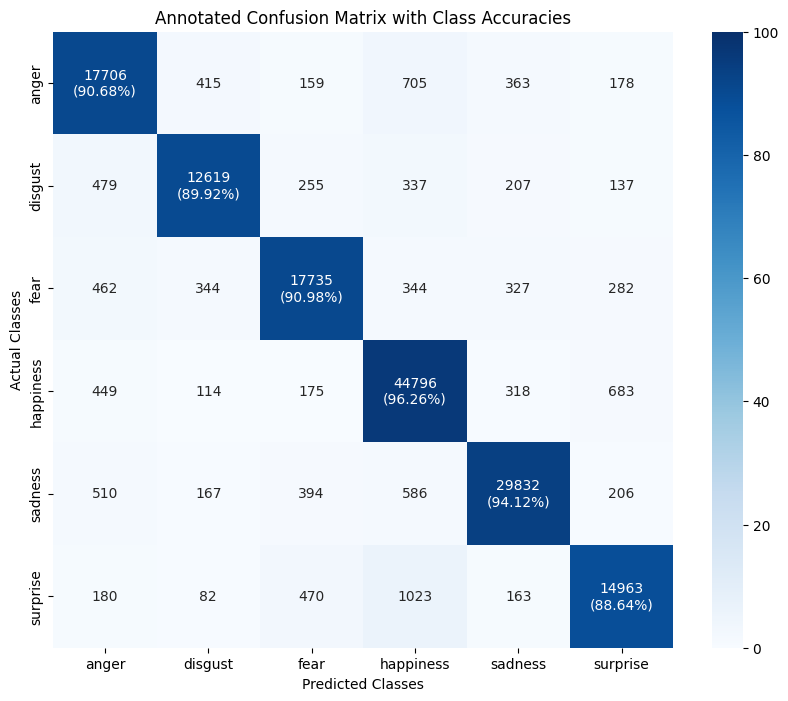

              precision    recall  f1-score   support

       anger       0.89      0.91      0.90     19526
     disgust       0.92      0.90      0.91     14034
        fear       0.92      0.91      0.92     19494
   happiness       0.94      0.96      0.95     46535
     sadness       0.96      0.94      0.95     31695
    surprise       0.91      0.89      0.90     16881

    accuracy                           0.93    148165
   macro avg       0.92      0.92      0.92    148165
weighted avg       0.93      0.93      0.93    148165

Total misclassified examples: 10514


In [15]:
# Predict the test set results
model_predictions = model.predict({"input_ids": X_val_tensors, "attention_mask": validation_masks_tensors})
class_predictions = np.argmax(model_predictions.logits, axis=1)

# Constructing the confusion matrix
confusion_mat = confusion_matrix(y_val_tensors, class_predictions)

# Deriving accuracy for each class from the confusion matrix
class_accuracy = confusion_mat.diagonal() / confusion_mat.sum(axis=1)

# Create a matrix for color scaling with percentage values only
percentage_matrix = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

# Create an annotated matrix for displaying the values
annotated_matrix = np.array(percentage_matrix, dtype=object)

for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        if i == j:  # Diagonal elements (correct classifications)
            percent_value = percentage_matrix[i, j]
            annotated_matrix[i, j] = f"{confusion_mat[i, j]}\n({percent_value:.2f}%)"
        else:  # Off-diagonal elements (misclassifications)
            # For misclassified, display only the count
            annotated_matrix[i, j] = f"{confusion_mat[i, j]}"

# Visualization of the confusion matrix with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(percentage_matrix, annot=annotated_matrix, fmt='', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            vmin=0, vmax=100)  # Adjust the color scale to match percentage values

plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.title('Annotated Confusion Matrix with Class Accuracies')
plt.show()

# Printing a comprehensive classification report
detailed_report = classification_report(y_val_tensors, class_predictions, target_names=encoder.classes_)
print(detailed_report)

# Identify misclassified examples
misclassified_idxs = np.where(y_val_tensors != class_predictions)[0]
print(f"Total misclassified examples: {len(misclassified_idxs)}")

## Predicting on the "test" dataset

In [16]:
# Importing the Test Data
test_data_frame = pd.read_csv('test_group.csv', delimiter='\t')

# Extracting Sentences for Classification from the 'sentence' Column
classification_text = test_data_frame['sentence'].values

# Initializing Containers for Token IDs and Attention Masks
tokenized_test_ids = []
tokenized_test_masks = []

# Encoding Process for the Test Data
for text in classification_text:
    encoded_text = text_tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=MAX_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='tf',
                    )
    
    tokenized_test_ids.append(encoded_text['input_ids'])
    tokenized_test_masks.append(encoded_text['attention_mask'])

# Conversion of List Structures to Tensor Structures
tokenized_test_ids = tf.concat(tokenized_test_ids, axis=0)
tokenized_test_masks = tf.concat(tokenized_test_masks, axis=0)

In [17]:
# Performing Model Predictions on the Tokenized Test Data
model_prediction_results = model.predict({"input_ids": tokenized_test_ids, "attention_mask": tokenized_test_masks})
model_predicted_classes = np.argmax(model_prediction_results.logits, axis=1)

45/45 [==============================] - 4s 81ms/step


In [18]:
# Translating Predicted Class Indices to Original Class Labels
translated_predicted_labels = encoder.inverse_transform(model_predicted_classes)

# Constructing a DataFrame to Present ID and Predicted Labels
final_predictions_data_frame = pd.DataFrame({
    "id": test_data_frame['id'],
    "predicted_label": translated_predicted_labels
})

In [19]:
# Showcasing the Initial Few Predictions
print(final_predictions_data_frame.head())

   id predicted_label
0   0       happiness
1   1        surprise
2   2         disgust
3   3         disgust
4   4           anger


In [20]:
# Save the predictions into a CSV file for further analysis and/or submission
final_predictions_data_frame.to_csv('roberta_finetuned_full_dataset.csv', index=False)

## Saving the model & tokenizer

In [22]:
model_save_path = 'model_full_dataset_V1'
tokenizer_save_path = 'tokenizer_full_dataset_V1'

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer associated with the model
text_tokenizer.save_pretrained(tokenizer_save_path)

('tokenizer_full_dataset_V1/tokenizer_config.json',
 'tokenizer_full_dataset_V1/special_tokens_map.json',
 'tokenizer_full_dataset_V1/vocab.json',
 'tokenizer_full_dataset_V1/merges.txt',
 'tokenizer_full_dataset_V1/added_tokens.json')

---

## Error analysis

In [25]:
# This will be a dictionary to hold indices for misclassified examples for each emotion.
misclassified_per_emotion = defaultdict(list)

# Iterate through all misclassified indices and categorize them by true label
for idx in misclassified_idxs:
    true_label = y_val_tensors[idx]
    predicted_label = class_predictions[idx]
    if true_label != predicted_label:
        emotion = encoder.inverse_transform([true_label])[0]
        misclassified_per_emotion[emotion].append(idx)

# Now, for each emotion, randomly pick up to 5 misclassified examples and print them
for emotion, indices in misclassified_per_emotion.items():
    print(f"\033[1m--- Misclassified '{emotion}' examples ---\033[0m")  # Bold
    if len(indices) > 5:
        indices = random.sample(indices, 5)  # Randomly pick 5 if there are more than 5
    for idx in indices:
        sentence = text_data[idx]
        true_label = encoder.inverse_transform([y_val_tensors[idx]])[0]
        predicted_label = encoder.inverse_transform([class_predictions[idx]])[0]
        print(f"Sentence: {sentence}")
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}\n")

--- Misclassified 'surprise' examples ---
Sentence: I know about have to do largely with the fact that any feelings romantic or sexual i have successfully hidden from myself.
True Label: surprise, Predicted Label: happiness

Sentence: I feeling worthless.
True Label: surprise, Predicted Label: happiness

Sentence: What a nasty goal! Gives you chills!
True Label: surprise, Predicted Label: happiness

Sentence: Kinda weird after you find out he wrote those songs while thinking about underage girls.
True Label: surprise, Predicted Label: anger

Sentence: I I'm so honored.
True Label: surprise, Predicted Label: happiness

--- Misclassified 'anger' examples ---
Sentence: I feel like struggled isnt even a strong enough word for yesterday.
True Label: anger, Predicted Label: disgust

Sentence: Does this attitude go for anything where you accidently end up killing someone via stupid behaviour?
True Label: anger, Predicted Label: surprise

Sentence: I do not want to feel resentful and bitter.
T

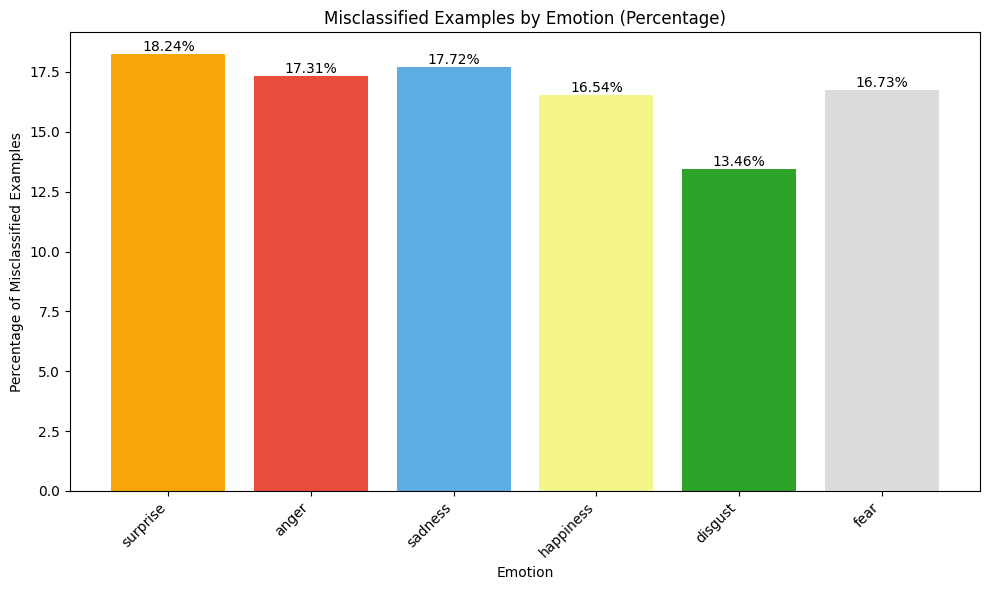

In [27]:
# Initialize a dictionary to hold the count of misclassified sentences for each emotion
misclassified_counts = defaultdict(int)

# Count the misclassified examples for each emotion
for idx in misclassified_idxs:
    true_label = y_val_tensors[idx]
    predicted_label = class_predictions[idx]
    if true_label != predicted_label:
        emotion = encoder.inverse_transform([true_label])[0]
        misclassified_counts[emotion] += 1

# Calculate the total number of misclassified examples
total_misclassified = sum(misclassified_counts.values())

# Convert counts to percentages
misclassified_percentages = {emotion: (count / total_misclassified) * 100 for emotion, count in misclassified_counts.items()}

# Specific colors for each emotion
emotion_colors = {
    'happiness': '#F4F68A',
    'sadness': '#5DADE2',
    'anger': '#E74C3C',
    'fear': '#DCDCDC',
    'disgust': '#2DA329',
    'surprise': '#FAA60A'
}

# Generating a list of colors in the order of emotions in misclassified_percentages
colors = [emotion_colors[emotion] for emotion in misclassified_percentages.keys()]

# Plotting
plt.figure(figsize=(10, 6))

# Plotting the bar chart with specific colors for each emotion
bars = plt.bar(misclassified_percentages.keys(), misclassified_percentages.values(), color=colors)

# Adding labels and title
plt.xlabel('Emotion')
plt.ylabel('Percentage of Misclassified Examples')
plt.title('Misclassified Examples by Emotion (Percentage)')

# Adding the percentage of misclassified examples on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

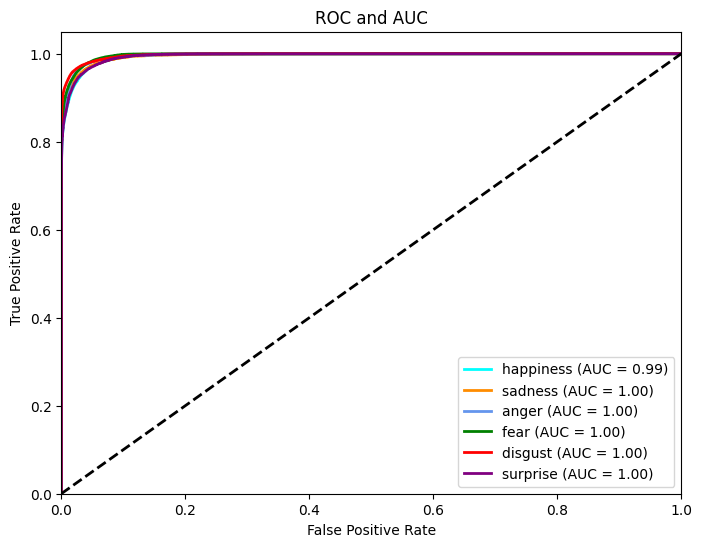

In [29]:
logits = model_predictions.logits
y_prob = tf.nn.softmax(logits).numpy()

# Binarize the output
y_val_binarized = label_binarize(y_val_tensors, classes=np.unique(y_val_tensors))
n_classes = y_val_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Defining each emotion
emotion_names = ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, (color, emotion) in enumerate(zip(colors, emotion_names)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(emotion, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="lower right")
plt.show()